# YUVA Sales Prediction Model
## Gradient Boosting with Log Transform

This notebook builds a sales prediction model for the YUVA model family using:
- Log transformation on target variable
- Base features and seasonality
- Gradient Boosting Regressor

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
import pickle

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully")

Libraries imported successfully


## Cell 2: Load Dataset
Load the tertiary sales data with seasonality features from CSV file.

In [202]:
df = pd.read_csv('/content/tertiary_2024_with_seasonality.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset Shape: (1970, 17)
Columns: ['week', 'Year', 'model_code', 'model_family', 'start_date', 'end_date', 'ret_stock', 'ret_dos', 'dbr_stock', 'dbr_dos', 'wod', 'stocking_outlet', 'activating_outlet', 'plc_factor', 'tertiary', 'seasonality_1', 'seasonality_2']


,week,Year,model_code,model_family,start_date,end_date,ret_stock,ret_dos,dbr_stock,dbr_dos,wod,stocking_outlet,activating_outlet,plc_factor,tertiary,seasonality_1,seasonality_2
0,1,2024,LZG404_YUVA,YUVA,NaN,NaN,3565,107.103004,692,20.789700,3575,2718,186,100,233,0.106293,0.994335
1,1,2024,LZX415_YUVA_3,YUVA,NaN,NaN,0,0.000000,0,0.000000,10,0,0,100,0,0.106293,0.994335
2,1,2024,YUVA_3_128GB,YUVA,NaN,NaN,0,0.000000,0,0.000000,10,0,0,100,0,0.106293,0.994335
3,1,2024,LZX411_YUVA2,YUVA,NaN,NaN,14362,88.265145,2263,13.907814,14372,10077,911,100,1139,0.106293,0.994335
4,1,2024,LZX408_YUVA2PRO,YUVA,NaN,NaN,20815,121.725146,4420,25.847953,20825,13608,958,100,1197,0.106293,0.994335


## Cell 3: Data Exploration
Check for missing values, target variable statistics, and available model families.

In [203]:
print("Missing Values:")
print(df.isnull().sum())

print(f"\nTarget Variable Statistics:")
print(df['tertiary'].describe())

print(f"\nModel Families:")
print(df['model_family'].value_counts())

Missing Values:
week                    0
Year                    0
model_code              0
model_family            0
start_date           1970
end_date             1970
ret_stock               0
ret_dos                 0
dbr_stock               0
dbr_dos                 0
wod                     0
stocking_outlet         0
activating_outlet       0
plc_factor              0
tertiary                0
seasonality_1           0
seasonality_2           0
dtype: int64

Target Variable Statistics:
count     1970.000000
mean      3148.404569
std       8734.920279
min          0.000000
25%         20.000000
50%        161.000000
75%       1454.000000
max      63467.000000
Name: tertiary, dtype: float64

Model Families:
model_family
YUVA    1619
JOSH     117
A3       117
A7       117
Name: count, dtype: int64


## Cell 4: Data Preprocessing
- Convert date columns to datetime
- Fill missing numeric values with median
- Remove duplicates and filter for YUVA model family
- Extract year from data

In [204]:
for col in ['start_date', 'end_date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

df = df.drop_duplicates()
df = df.sort_values(['model_family', 'week']).reset_index(drop=True)

df = df[df['model_family'].str.upper() == 'YUVA'].copy()
print(f"YUVA family shape: {df.shape}")

if 'Year' in df.columns:
    df['year'] = df['Year']
elif 'start_date' in df.columns:
    df['year'] = df['start_date'].dt.year

print(f"Years: {sorted(df['year'].unique())}")

YUVA family shape: (1619, 17)
Years: [np.int64(2024), np.int64(2025)]


## Cell 5: Target Distribution Analysis
Visualize the target variable distribution before and after log transformation.
Log transformation reduces skewness and helps the model learn better.

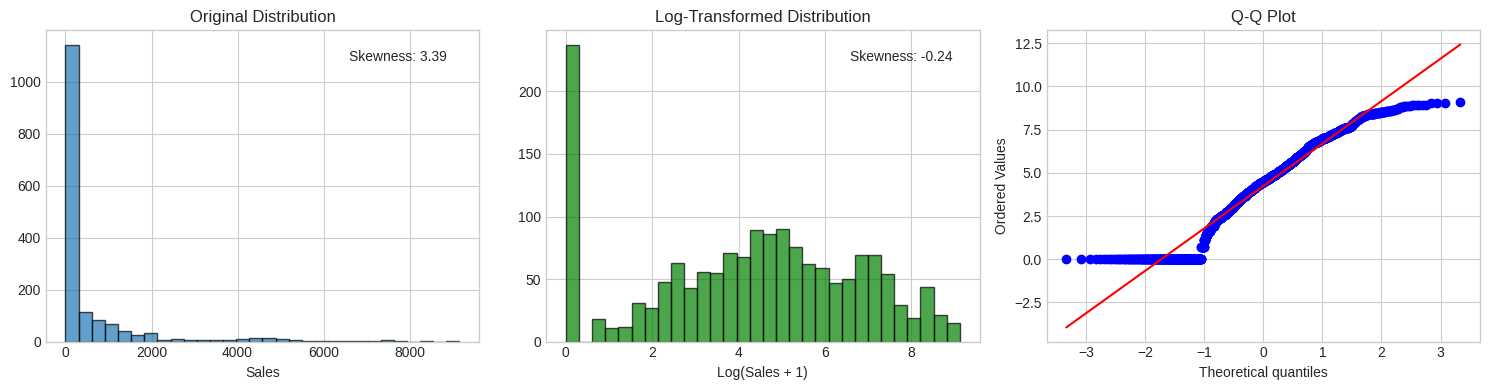

Original Skewness: 3.389
Log-Transformed Skewness: -0.241


In [205]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['tertiary'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Sales')
skew_original = stats.skew(df['tertiary'])
axes[0].text(0.7, 0.9, f'Skewness: {skew_original:.2f}', transform=axes[0].transAxes)

log_tertiary = np.log1p(df['tertiary'])
axes[1].hist(log_tertiary, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Log-Transformed Distribution')
axes[1].set_xlabel('Log(Sales + 1)')
skew_log = stats.skew(log_tertiary)
axes[1].text(0.7, 0.9, f'Skewness: {skew_log:.2f}', transform=axes[1].transAxes)

stats.probplot(log_tertiary, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"Original Skewness: {skew_original:.3f}")
print(f"Log-Transformed Skewness: {skew_log:.3f}")

## Cell 6: Define Features
Define the feature columns for the model:
- Base features: week, stock levels, distribution metrics
- Seasonality features: seasonality_1, seasonality_2

In [206]:
df = df.sort_values('week').reset_index(drop=True)

FEATURE_COLUMNS = [
    'week', 'ret_stock', 'ret_dos', 'dbr_stock', 'dbr_dos',
    'wod', 'stocking_outlet', 'activating_outlet', 'plc_factor',
    'seasonality_1', 'seasonality_2'
]

TARGET_COLUMN = 'tertiary'

print(f"Total Features: {len(FEATURE_COLUMNS)}")
print(f"Features: {FEATURE_COLUMNS}")

Total Features: 11
Features: ['week', 'ret_stock', 'ret_dos', 'dbr_stock', 'dbr_dos', 'wod', 'stocking_outlet', 'activating_outlet', 'plc_factor', 'seasonality_1', 'seasonality_2']


## Cell 7: Train-Test Split
Time-based split to prevent data leakage:
- **Training**: 2024 data + 80% of 2025 data
- **Testing**: Last 20% of 2025 data

In [207]:
df_2024 = df[df['year'] == 2024].copy()
df_2025 = df[df['year'] == 2025].sort_values('week').copy()

test_size = int(0.2 * len(df_2025))
if test_size == 0:
    test_size = max(1, len(df_2025))

df_test = df_2025.tail(test_size)
df_2025_train = df_2025.head(len(df_2025) - test_size)

df_train = pd.concat([df_2024, df_2025_train], ignore_index=True)

print(f"Training: {len(df_train)} records")
print(f"Testing: {len(df_test)} records")
if len(df_test) > 0:
    print(f"Test weeks: {df_test['week'].min()} to {df_test['week'].max()}")

Training: 1445 records
Testing: 174 records
Test weeks: 47 to 57


## Cell 8: Data Preparation
- Extract features and target variable
- Apply RobustScaler for feature scaling
- Apply log transformation to target variable (log1p)

In [208]:
missing_cols = [col for col in FEATURE_COLUMNS if col not in df_train.columns]
if missing_cols:
    print(f"Warning: Missing columns removed: {missing_cols}")
    FEATURE_COLUMNS = [col for col in FEATURE_COLUMNS if col in df_train.columns]

X_train = df_train[FEATURE_COLUMNS].copy()
X_test = df_test[FEATURE_COLUMNS].copy()

y_train = df_train[TARGET_COLUMN].copy()
y_test = df_test[TARGET_COLUMN].copy()

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Features: {len(FEATURE_COLUMNS)}")

X_train shape: (1445, 11)
X_test shape: (174, 11)
Features: 11


## Cell 9: Define Metrics Function
Calculate evaluation metrics:
- **R2 Score**: Coefficient of determination
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error
- **MAPE**: Mean Absolute Percentage Error
- **Accuracy**: 100 - MAPE

In [209]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    denominator = np.clip(np.abs(y_true), 1, None)
    mape = np.mean(np.abs((y_true - y_pred) / denominator)) * 100

    accuracy = max(0, 100 - mape)

    return {
        'Model': model_name,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy
    }

print("Metrics function defined")

Metrics function defined


## Cell 10: Train Gradient Boosting Model
Train the model with optimized hyperparameters:
- n_estimators: 200
- max_depth: 5
- learning_rate: 0.05
- subsample: 0.8

Predictions are inverse log-transformed using expm1.

In [210]:
print("Training Gradient Boosting...")

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.06,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train_log)

gb_pred_log = gb_model.predict(X_test_scaled)
gb_pred = np.expm1(gb_pred_log)
gb_pred = np.clip(gb_pred, 0, None)

metrics = calculate_metrics(y_test, gb_pred, "GradientBoosting")

print("Gradient Boosting trained successfully")

Training Gradient Boosting...
Gradient Boosting trained successfully


## Cell 11: Model Results
Display the evaluation metrics for the trained Gradient Boosting model.

In [211]:

print("GRADIENT BOOSTING MODEL RESULTS")
print(f"R2 Score:   {metrics['R2']:.4f}")
print(f"MAE:        {metrics['MAE']:.2f}")
print(f"RMSE:       {metrics['RMSE']:.2f}")
print(f"MAPE:       {metrics['MAPE']:.2f}%")
print(f"Accuracy:   {metrics['Accuracy']:.2f}%")


GRADIENT BOOSTING MODEL RESULTS
R2 Score:   0.9979
MAE:        19.00
RMSE:       49.92
MAPE:       9.45%
Accuracy:   90.55%


## Cell 13: Actual vs Predicted Plot
Scatter plot comparing actual sales with predicted sales.
The red dashed line represents perfect prediction.

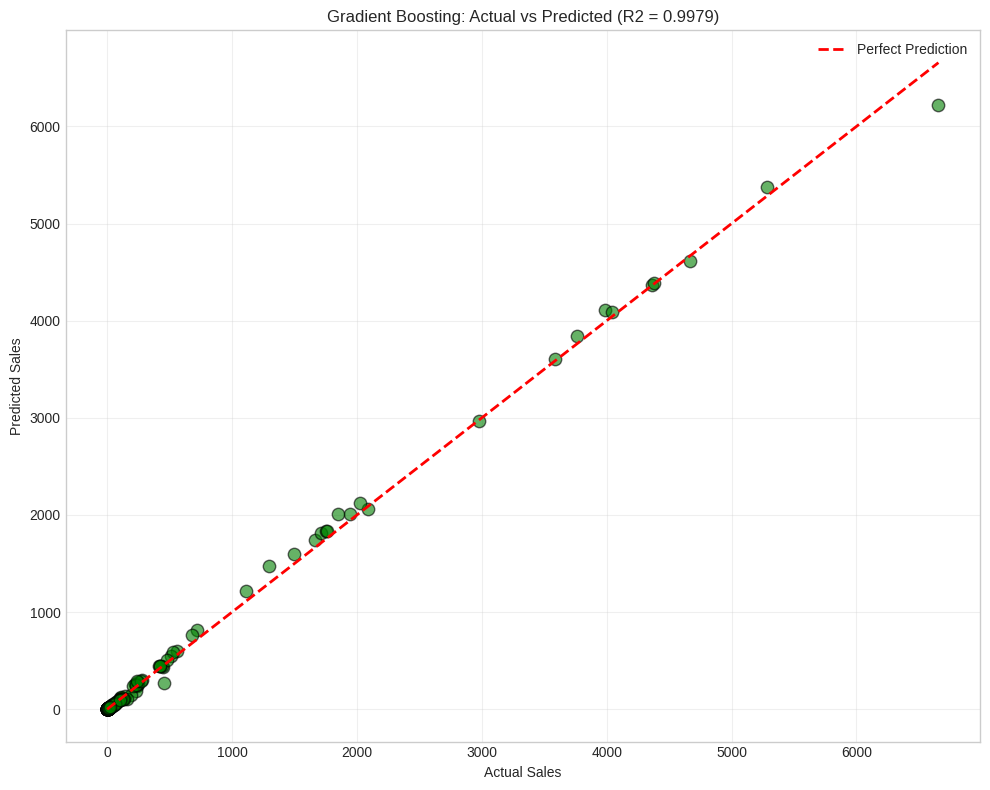

In [212]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(y_test, gb_pred, alpha=0.6, edgecolors='black', s=80, color='green')
max_val = max(y_test.max(), max(gb_pred)) if len(y_test) > 0 else 1
ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')
ax.set_title(f'Gradient Boosting: Actual vs Predicted (R2 = {metrics["R2"]:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 16: Save Predictions to Excel
Export predictions, metrics, and feature importance to Excel file.

In [213]:
base_cols = ['week', 'year']
available_base = [col for col in base_cols if col in df_test.columns]

output_df = df_test[available_base].copy()
output_df['Actual'] = y_test.values
output_df['Predicted'] = gb_pred
output_df['Error'] = output_df['Actual'] - output_df['Predicted']
output_df['Error_Pct'] = (output_df['Error'] / output_df['Actual'].clip(lower=1)) * 100

metrics_df = pd.DataFrame([metrics])
metrics_df = metrics_df.round(4)

try:
    with pd.ExcelWriter('YUVA_GradientBoosting_Predictions.xlsx', engine='openpyxl') as writer:
        output_df.to_excel(writer, sheet_name='Predictions', index=False)
        metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
        importance_df.to_excel(writer, sheet_name='FeatureImportance', index=False)
    print("Saved: YUVA_GradientBoosting_Predictions.xlsx")
except Exception as e:
    output_df.to_csv('YUVA_GradientBoosting_Predictions.csv', index=False)
    print("Saved: YUVA_GradientBoosting_Predictions.csv")

Saved: YUVA_GradientBoosting_Predictions.csv


## Cell 17: Report
Save the trained model, scaler, and configuration to a pickle file for future use.

In [214]:
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

pdf_filename = 'YUVA_Model_Complete_Report.pdf'

with PdfPages(pdf_filename) as pdf:

    # Page 1: Title and Model Summary
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    title_text = "YUVA Sales Prediction Model\nComplete Analysis Report"
    ax.text(0.5, 0.85, title_text, fontsize=24, fontweight='bold',
            ha='center', va='top', transform=ax.transAxes)

    summary_text = f"""
    Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

    MODEL CONFIGURATION
    {'='*50}
    Algorithm: Gradient Boosting Regressor
    n_estimators: 300
    max_depth: 7
    learning_rate: 0.06
    subsample: 0.8

    DATA SUMMARY
    {'='*50}
    Model Family: YUVA
    Total Features: {len(FEATURE_COLUMNS)}
    Training Samples: {len(df_train)}
    Testing Samples: {len(df_test)}

    MODEL PERFORMANCE
    {'='*50}
    R2 Score:     {metrics['R2']:.4f}
    MAE:          {metrics['MAE']:.2f}
    RMSE:         {metrics['RMSE']:.2f}
    MAPE:         {metrics['MAPE']:.2f}%
    Accuracy:     {metrics['Accuracy']:.2f}%
    """

    ax.text(0.5, 0.65, summary_text, fontsize=12, family='monospace',
            ha='center', va='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 2: Target Distribution Analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Target Variable Distribution Analysis', fontsize=14, fontweight='bold')

    axes[0].hist(df['tertiary'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_title('Original Distribution')
    axes[0].set_xlabel('Sales')
    axes[0].set_ylabel('Frequency')
    skew_orig = stats.skew(df['tertiary'])
    axes[0].text(0.7, 0.9, f'Skewness: {skew_orig:.2f}', transform=axes[0].transAxes)

    log_tert = np.log1p(df['tertiary'])
    axes[1].hist(log_tert, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_title('Log-Transformed Distribution')
    axes[1].set_xlabel('Log(Sales + 1)')
    axes[1].set_ylabel('Frequency')
    skew_log = stats.skew(log_tert)
    axes[1].text(0.7, 0.9, f'Skewness: {skew_log:.2f}', transform=axes[1].transAxes)

    stats.probplot(log_tert, dist="norm", plot=axes[2])
    axes[2].set_title('Q-Q Plot (Log-Transformed)')

    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 3: Actual vs Predicted Scatter Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(y_test, gb_pred, alpha=0.6, edgecolors='black', s=80, color='green')
    max_val = max(y_test.max(), max(gb_pred)) if len(y_test) > 0 else 1
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Sales', fontsize=12)
    ax.set_ylabel('Predicted Sales', fontsize=12)
    ax.set_title(f'Actual vs Predicted Sales\n(R2 = {metrics["R2"]:.4f}, Accuracy = {metrics["Accuracy"]:.2f}%)',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 4: Prediction Error Analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Prediction Error Analysis', fontsize=14, fontweight='bold')

    errors = y_test.values - gb_pred
    error_pct = (errors / np.clip(y_test.values, 1, None)) * 100

    axes[0].hist(errors, bins=25, edgecolor='black', alpha=0.7, color='coral')
    axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
    axes[0].set_title('Error Distribution')
    axes[0].set_xlabel('Prediction Error')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(error_pct, bins=25, edgecolor='black', alpha=0.7, color='mediumpurple')
    axes[1].axvline(x=0, color='red', linestyle='--', lw=2)
    axes[1].set_title('Percentage Error Distribution')
    axes[1].set_xlabel('Error %')
    axes[1].set_ylabel('Frequency')

    if 'week' in df_test.columns:
        week_data = df_test['week'].values
        axes[2].plot(week_data, y_test.values, 'b-o', label='Actual', markersize=6)
        axes[2].plot(week_data, gb_pred, 'r--s', label='Predicted', markersize=6)
        axes[2].set_title('Sales Trend: Actual vs Predicted')
        axes[2].set_xlabel('Week')
        axes[2].set_ylabel('Sales')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Page 5: Predictions Table
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    ax.text(0.5, 0.98, 'Predictions Summary', fontsize=18, fontweight='bold',
            ha='center', va='top', transform=ax.transAxes)

    pred_df = pd.DataFrame({
        'Week': df_test['week'].values if 'week' in df_test.columns else range(len(y_test)),
        'Actual': y_test.values,
        'Predicted': np.round(gb_pred, 2),
        'Error': np.round(errors, 2),
        'Error%': np.round(error_pct, 2)
    })

    table = ax.table(
        cellText=pred_df.values,
        colLabels=pred_df.columns,
        cellLoc='center',
        loc='center',
        colColours=['lightsteelblue']*len(pred_df.columns)
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"Complete report saved: {pdf_filename}")
print("\nReport includes:")
print("  1. Model Summary and Configuration")
print("  2. Target Distribution Analysis")
print("  3. Actual vs Predicted Plot")
print("  4. Error Analysis Plots")
print("  5. Predictions Summary Table")

Complete report saved: YUVA_Model_Complete_Report.pdf

Report includes:
  1. Model Summary and Configuration
  2. Target Distribution Analysis
  3. Actual vs Predicted Plot
  4. Error Analysis Plots
  5. Predictions Summary Table


In [215]:
model_artifact = {
    'model': gb_model,
    'scaler': scaler,
    'features': FEATURE_COLUMNS,
    'log_transform': True,
    'metrics': metrics
}

try:
    with open('yuva_gradient_boosting_model.pkl', 'wb') as f:
        pickle.dump(model_artifact, f)
    print("Saved: yuva_gradient_boosting_model.pkl")
    print(f"Features: {len(FEATURE_COLUMNS)}")
except Exception as e:
    print(f"Error saving model: {e}")

Saved: yuva_gradient_boosting_model.pkl
Features: 11
